In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

np.random.seed(42)
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True
print('Libraries loaded ✓')

Libraries loaded ✓


Dataset: (3000, 2), Class balance: 0.463
Train: (2100, 2)  Val: (450, 2)  Test: (450, 2)


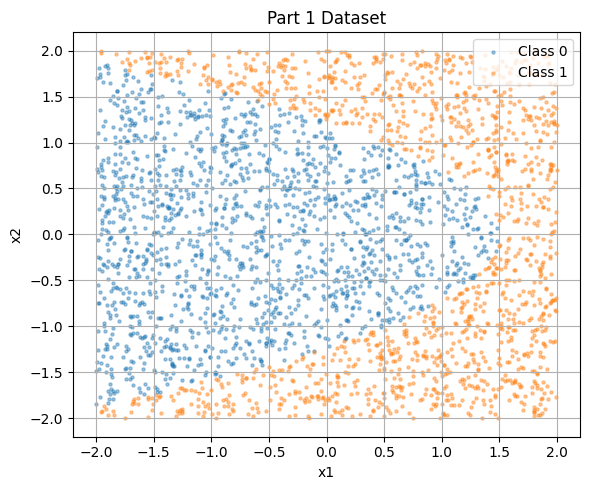

In [2]:
# ─────────────────────────────────────
# DATASET GENERATION
# ─────────────────────────────────────
N = 3000
x1 = np.random.uniform(-2, 2, N)
x2 = np.random.uniform(-2, 2, N)
X_all = np.column_stack([x1, x2])          # (3000, 2)
y_all = ((x1 + x2**2) > 1.5).astype(float).reshape(-1, 1)

print(f'Dataset: {X_all.shape}, Class balance: {y_all.mean():.3f}')

# 70 / 15 / 15 split
idx = np.random.permutation(N)
train_end = int(0.70 * N)
val_end   = int(0.85 * N)

X_train, y_train = X_all[idx[:train_end]],  y_all[idx[:train_end]]
X_val,   y_val   = X_all[idx[train_end:val_end]], y_all[idx[train_end:val_end]]
X_test,  y_test  = X_all[idx[val_end:]],    y_all[idx[val_end:]]

print(f'Train: {X_train.shape}  Val: {X_val.shape}  Test: {X_test.shape}')

# Visualise
plt.figure(figsize=(6,5))
plt.scatter(x1[y_all[:,0]==0], x2[y_all[:,0]==0], s=5, alpha=0.4, label='Class 0')
plt.scatter(x1[y_all[:,0]==1], x2[y_all[:,0]==1], s=5, alpha=0.4, label='Class 1')
plt.title('Part 1 Dataset'); plt.xlabel('x1'); plt.ylabel('x2'); plt.legend()
plt.tight_layout(); plt.savefig('p1_dataset.png', dpi=100); plt.show()

In [3]:
# ─────────────────────────────────────
# ACTIVATION FUNCTIONS
# ─────────────────────────────────────
def sigmoid(z):     return 1.0 / (1.0 + np.exp(-np.clip(z, -500, 500)))
def sigmoid_d(z):   s = sigmoid(z); return s * (1 - s)
def relu(z):        return np.maximum(0, z)
def relu_d(z):      return (z > 0).astype(float)

# BCE with numerical stability
EPS = 1e-8
def bce_loss(y_hat, y):
    y_hat = np.clip(y_hat, EPS, 1 - EPS)
    return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

def bce_grad(y_hat, y):
    y_hat = np.clip(y_hat, EPS, 1 - EPS)
    return (y_hat - y) / (y_hat * (1 - y_hat) * len(y))

def accuracy(y_hat, y):
    return np.mean((y_hat >= 0.5).astype(float) == y)

def frobenius_norm(grads):
    return [np.sqrt(np.sum(g**2)) for g in grads]

print('Activations & utilities defined ✓')

Activations & utilities defined ✓


In [4]:
# ─────────────────────────────────────
# DENSE NEURAL NETWORK (from scratch)
# ─────────────────────────────────────
class DenseNet:
    """
    Fully-connected network.
    layers_dims: list of ints, e.g. [2, 16, 16, 1]
    activation : 'sigmoid' or 'relu'  (hidden layers)
    """
    def __init__(self, layers_dims, activation='relu'):
        self.L = len(layers_dims) - 1          # number of weight layers
        self.act_name = activation
        self.act  = sigmoid if activation == 'sigmoid' else relu
        self.act_d= sigmoid_d if activation == 'sigmoid' else relu_d
        # He init for ReLU, Xavier for sigmoid
        self.W, self.b = [], []
        for l in range(self.L):
            fan_in  = layers_dims[l]
            fan_out = layers_dims[l+1]
            scale = np.sqrt(2/fan_in) if activation == 'relu' else np.sqrt(1/fan_in)
            self.W.append(np.random.randn(fan_in, fan_out) * scale)
            self.b.append(np.zeros((1, fan_out)))
        # count params
        self.n_params = sum(w.size + b.size for w,b in zip(self.W, self.b))

    def forward(self, X):
        self.Z, self.A = [], [X]
        for l in range(self.L):
            z = self.A[-1] @ self.W[l] + self.b[l]
            self.Z.append(z)
            if l < self.L - 1:
                self.A.append(self.act(z))
            else:
                self.A.append(sigmoid(z))   # output always sigmoid
        return self.A[-1]

    def backward(self, y):
        m = y.shape[0]
        dA = bce_grad(self.A[-1], y)
        dW_list, db_list, grad_norms = [], [], []
        for l in reversed(range(self.L)):
            # dZ
            if l == self.L - 1:
                dZ = dA * sigmoid_d(self.Z[l])
            else:
                dZ = dA * self.act_d(self.Z[l])
            dW = self.A[l].T @ dZ
            db = np.sum(dZ, axis=0, keepdims=True)
            dA = dZ @ self.W[l].T
            dW_list.insert(0, dW)
            db_list.insert(0, db)
            grad_norms.insert(0, np.sqrt(np.sum(dW**2)))
        return dW_list, db_list, grad_norms

    def count_params(self):
        print(f'  Total parameters: {self.n_params}')
        for l, (w, b) in enumerate(zip(self.W, self.b)):
            print(f'  Layer {l+1}: W{w.shape} + b{b.shape} = {w.size+b.size}')

print('DenseNet class defined ✓')

DenseNet class defined ✓


In [5]:
# ─────────────────────────────────────
# OPTIMIZERS
# ─────────────────────────────────────
def sgd_update(W, b, dW, db, lr=0.01, **kw):
    for l in range(len(W)):
        W[l] -= lr * dW[l]
        b[l] -= lr * db[l]
    return W, b, kw

def momentum_update(W, b, dW, db, lr=0.01, beta=0.9, vW=None, vb=None, **kw):
    if vW is None:
        vW = [np.zeros_like(w) for w in W]
        vb = [np.zeros_like(bi) for bi in b]
    for l in range(len(W)):
        vW[l] = beta * vW[l] + lr * dW[l]
        vb[l] = beta * vb[l] + lr * db[l]
        W[l] -= vW[l]
        b[l] -= vb[l]
    return W, b, {'vW': vW, 'vb': vb}

def adam_update(W, b, dW, db, lr=0.001, beta1=0.9, beta2=0.999,
                eps=1e-8, mW=None, mb=None, vW=None, vb=None, t=0, **kw):
    if mW is None:
        mW = [np.zeros_like(w) for w in W]
        mb = [np.zeros_like(bi) for bi in b]
        vW = [np.zeros_like(w) for w in W]
        vb = [np.zeros_like(bi) for bi in b]
    t += 1
    for l in range(len(W)):
        mW[l] = beta1 * mW[l] + (1 - beta1) * dW[l]
        mb[l] = beta1 * mb[l] + (1 - beta1) * db[l]
        vW[l] = beta2 * vW[l] + (1 - beta2) * dW[l]**2
        vb[l] = beta2 * vb[l] + (1 - beta2) * db[l]**2
        mW_hat = mW[l] / (1 - beta1**t)
        mb_hat = mb[l] / (1 - beta1**t)
        vW_hat = vW[l] / (1 - beta2**t)
        vb_hat = vb[l] / (1 - beta2**t)
        W[l] -= lr * mW_hat / (np.sqrt(vW_hat) + eps)
        b[l] -= lr * mb_hat / (np.sqrt(vb_hat) + eps)
    return W, b, {'mW': mW, 'mb': mb, 'vW': vW, 'vb': vb, 't': t}

print('Optimizers defined ✓')

Optimizers defined ✓


In [10]:
import numpy as np
# ─────────────────────────────────────
# TRAINING LOOP (generic)
# ─────────────────────────────────────
def train_dense(net, X_tr, y_tr, X_v, y_v, optimizer='sgd',
                lr=0.01, epochs=300, batch_size=64, verbose=False):
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[], 'grad_norms':[]}
    opt_state = {}
    opt_fn = sgd_update if optimizer == 'sgd' else momentum_update
    n = X_tr.shape[0]

    for epoch in range(1, epochs+1):
        # mini-batch SGD
        idx = np.random.permutation(n)
        for start in range(0, n, batch_size):
            batch = idx[start:start+batch_size]
            Xb, yb = X_tr[batch], y_tr[batch]
            net.forward(Xb)
            dW, db, gnorms = net.backward(yb)
            net.W, net.b, opt_state = opt_fn(net.W, net.b, dW, db, lr=lr, **opt_state)

        # metrics
        # Calculate validation metrics first to avoid overwriting net.A[-1] before train metrics
        y_v_hat  = net.forward(X_v)
        history['val_loss'].append(bce_loss(y_v_hat,  y_v))
        history['val_acc'].append(accuracy(y_v_hat,  y_v))

        # Calculate train metrics and gradient norms
        y_tr_hat = net.forward(X_tr) # Ensure net.A[-1] is based on X_tr for backward pass
        _, _, gnorms = net.backward(y_tr)  # now net.A[-1] and y_tr match in size
        history['train_loss'].append(bce_loss(y_tr_hat, y_tr))
        history['train_acc'].append(accuracy(y_tr_hat, y_tr))
        history['grad_norms'].append(gnorms)

        if verbose and epoch % 50 == 0:
            print(f'Epoch {epoch:3d} | Loss {history["train_loss"][-1]:.4f} '
                  f'| Val Acc {history["val_acc"][-1]:.4f}')
    return history

print('Training loop defined ✓')

Training loop defined ✓


In [11]:
# ─────────────────────────────────────
# TASK 1A + 1C — Run all 12 experiments
# ─────────────────────────────────────
ARCHITECTURES = {
    '2-layer':  [2, 16, 1],
    '5-layer':  [2, 16, 16, 16, 16, 1],
    '10-layer': [2, 16, 16, 16, 16, 16, 16, 16, 16, 1],
}
ACTIVATIONS = ['sigmoid', 'relu']
OPTIMIZERS  = ['sgd', 'momentum']
EPOCHS      = 400
LR          = 0.05

results_p1 = {}  # key: (arch, act, opt)

for arch_name, dims in ARCHITECTURES.items():
    for act in ACTIVATIONS:
        for opt in OPTIMIZERS:
            key = (arch_name, act, opt)
            print(f'Training {arch_name} | {act} | {opt} ...', end=' ')
            net = DenseNet(dims, activation=act)
            hist = train_dense(net, X_train, y_train, X_val, y_val,
                               optimizer=opt, lr=LR, epochs=EPOCHS)
            # test metrics
            y_test_hat = net.forward(X_test)
            hist['test_loss'] = bce_loss(y_test_hat, y_test)
            hist['test_acc']  = accuracy(y_test_hat, y_test)
            hist['net']       = net
            results_p1[key]   = hist
            print(f'Done | Val Acc: {hist["val_acc"][-1]:.4f} | Test Acc: {hist["test_acc"]:.4f}')

print('\n✓ All Part 1 experiments complete')


Training 2-layer | sigmoid | sgd ... Done | Val Acc: 0.9800 | Test Acc: 0.9733
Training 2-layer | sigmoid | momentum ... Done | Val Acc: 0.9956 | Test Acc: 0.9889
Training 2-layer | relu | sgd ... Done | Val Acc: 0.9889 | Test Acc: 0.9889
Training 2-layer | relu | momentum ... Done | Val Acc: 0.9978 | Test Acc: 0.9867
Training 5-layer | sigmoid | sgd ... Done | Val Acc: 0.9778 | Test Acc: 0.9689
Training 5-layer | sigmoid | momentum ... Done | Val Acc: 0.9889 | Test Acc: 0.9711
Training 5-layer | relu | sgd ... Done | Val Acc: 0.9933 | Test Acc: 0.9889
Training 5-layer | relu | momentum ... Done | Val Acc: 0.9800 | Test Acc: 0.9778
Training 10-layer | sigmoid | sgd ... Done | Val Acc: 0.5200 | Test Acc: 0.5356
Training 10-layer | sigmoid | momentum ... Done | Val Acc: 0.5200 | Test Acc: 0.5356
Training 10-layer | relu | sgd ... Done | Val Acc: 0.9889 | Test Acc: 0.9867
Training 10-layer | relu | momentum ... Done | Val Acc: 0.9933 | Test Acc: 0.9822

✓ All Part 1 experiments complete


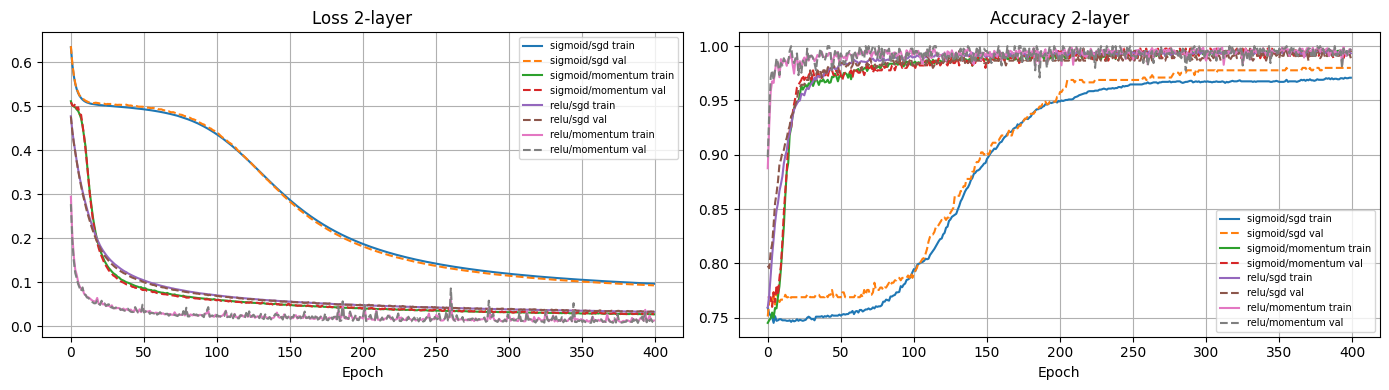

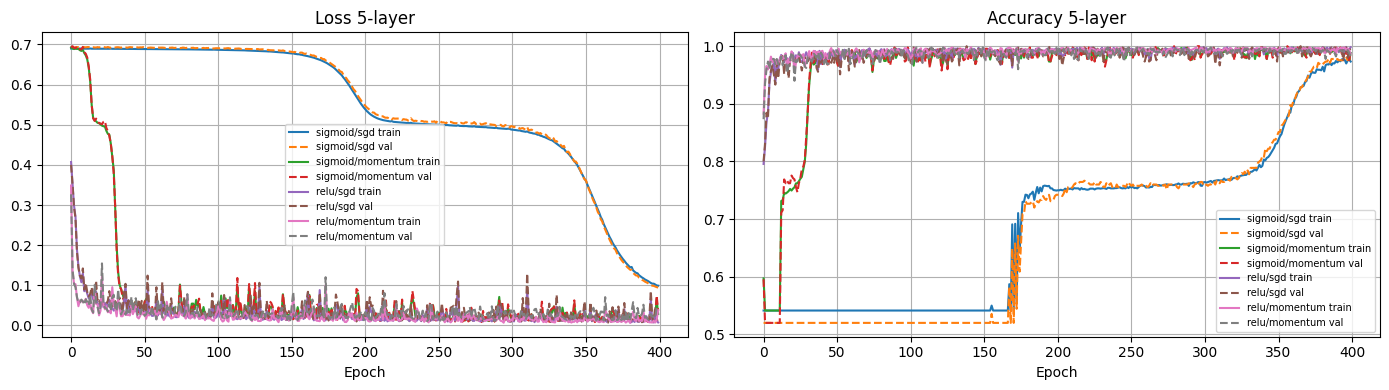

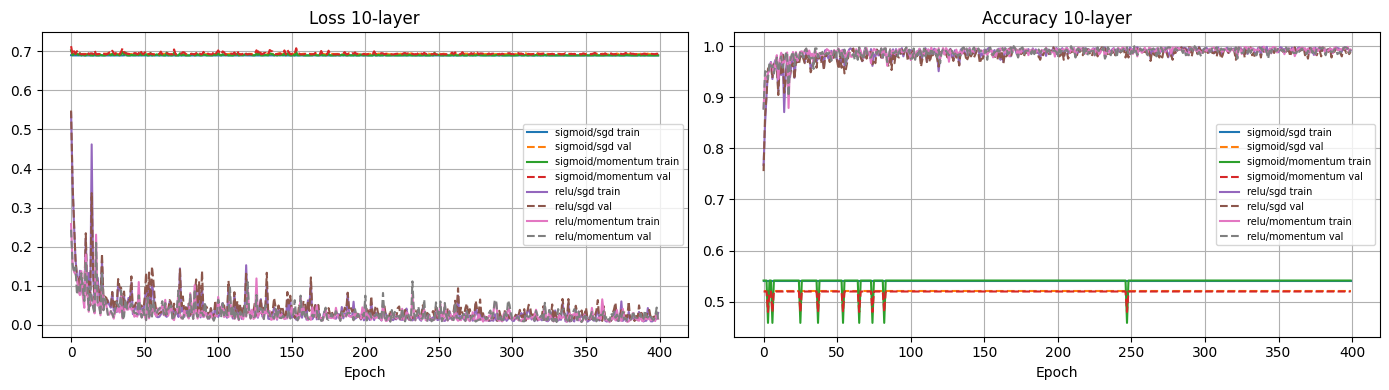

In [12]:
# ─────────────────────────────────────
# PLOT — Loss & Accuracy curves (per arch)
# ─────────────────────────────────────
def plot_history(hist_dict, title_suffix='', save_prefix='p1'):
    """Plot train/val loss and accuracy for a dict of histories."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    for label, hist in hist_dict.items():
        axes[0].plot(hist['train_loss'], label=f'{label} train')
        axes[0].plot(hist['val_loss'],   label=f'{label} val', linestyle='--')
        axes[1].plot(hist['train_acc'],  label=f'{label} train')
        axes[1].plot(hist['val_acc'],    label=f'{label} val', linestyle='--')
    axes[0].set_title(f'Loss {title_suffix}'); axes[0].set_xlabel('Epoch'); axes[0].legend(fontsize=7)
    axes[1].set_title(f'Accuracy {title_suffix}'); axes[1].set_xlabel('Epoch'); axes[1].legend(fontsize=7)
    plt.tight_layout(); plt.savefig(f'{save_prefix}_{title_suffix.replace(" ","_")}.png', dpi=100)
    plt.show()

# One plot per architecture
for arch_name in ARCHITECTURES:
    subset = {f'{act}/{opt}': results_p1[(arch_name, act, opt)]
              for act in ACTIVATIONS for opt in OPTIMIZERS}
    plot_history(subset, title_suffix=arch_name, save_prefix='p1')

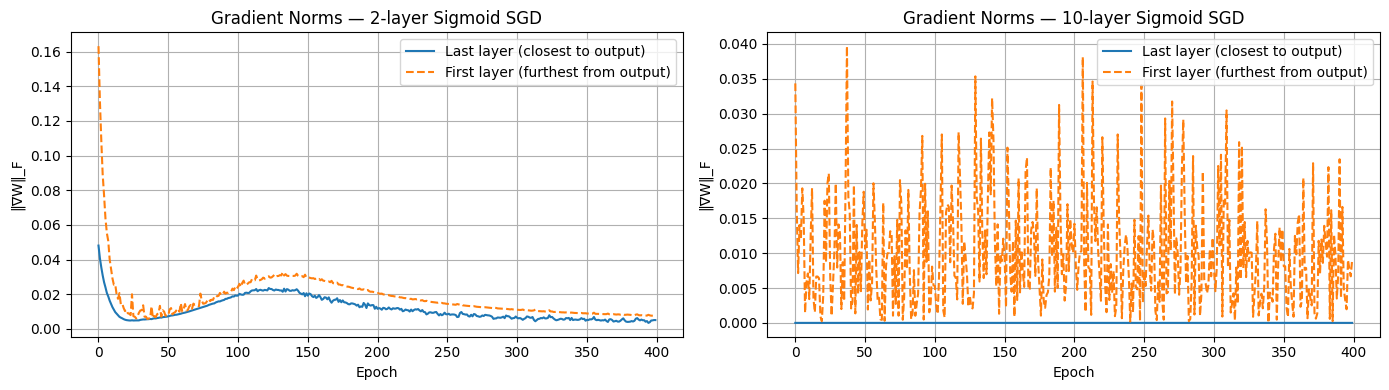


Observation: In the 10-layer sigmoid network, the first-layer gradient norms are
several orders of magnitude smaller — classic vanishing gradient problem.


In [13]:
# ─────────────────────────────────────
# ADD-ON — Gradient norm plots (first vs last layer)
# 2-layer sigmoid vs 10-layer sigmoid, SGD
# ─────────────────────────────────────
def extract_layer_gnorms(hist, layer_idx):
    return [gnorms[layer_idx] for gnorms in hist['grad_norms']]

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for ax_idx, (arch_name, n_layers) in enumerate([('2-layer', 2), ('10-layer', 10)]):
    hist = results_p1[(arch_name, 'sigmoid', 'sgd')]
    ax = axes[ax_idx]
    ax.plot(extract_layer_gnorms(hist, 0),  label='Last layer (closest to output)')
    ax.plot(extract_layer_gnorms(hist, -1), label='First layer (furthest from output)', linestyle='--')
    ax.set_title(f'Gradient Norms — {arch_name} Sigmoid SGD')
    ax.set_xlabel('Epoch'); ax.set_ylabel('‖∇W‖_F'); ax.legend()

plt.tight_layout(); plt.savefig('p1_gradient_norms.png', dpi=100); plt.show()
print('\nObservation: In the 10-layer sigmoid network, the first-layer gradient norms are'
      '\nseveral orders of magnitude smaller — classic vanishing gradient problem.')

In [14]:
# ─────────────────────────────────────
# MASTER RESULT TABLE — Part 1
# ─────────────────────────────────────
print(f'{'Model':<12} {'Act':<8} {'Opt':<10} {'Params':<8} {'TrainAcc':<10} {'ValAcc':<10} {'TestAcc':<10}')
print('-'*70)
for arch_name, dims in ARCHITECTURES.items():
    for act in ACTIVATIONS:
        for opt in OPTIMIZERS:
            hist = results_p1[(arch_name, act, opt)]
            n_params = hist['net'].n_params
            print(f'{arch_name:<12} {act:<8} {opt:<10} {n_params:<8} '
                  f'{hist["train_acc"][-1]:.4f}     '
                  f'{hist["val_acc"][-1]:.4f}     '
                  f'{hist["test_acc"]:.4f}')

Model        Act      Opt        Params   TrainAcc   ValAcc     TestAcc   
----------------------------------------------------------------------
2-layer      sigmoid  sgd        65       0.9710     0.9800     0.9733
2-layer      sigmoid  momentum   65       0.9957     0.9956     0.9889
2-layer      relu     sgd        65       0.9933     0.9889     0.9889
2-layer      relu     momentum   65       0.9967     0.9978     0.9867
5-layer      sigmoid  sgd        881      0.9733     0.9778     0.9689
5-layer      sigmoid  momentum   881      0.9881     0.9889     0.9711
5-layer      relu     sgd        881      0.9981     0.9933     0.9889
5-layer      relu     momentum   881      0.9871     0.9800     0.9778
10-layer     sigmoid  sgd        2241     0.5414     0.5200     0.5356
10-layer     sigmoid  momentum   2241     0.5414     0.5200     0.5356
10-layer     relu     sgd        2241     0.9910     0.9889     0.9867
10-layer     relu     momentum   2241     0.9933     0.9933     0.9822


Image dataset: (3000, 8, 8), Labels: (3000, 1)
Train: (2100, 8, 8)  Val: (450, 8, 8)  Test: (450, 8, 8)


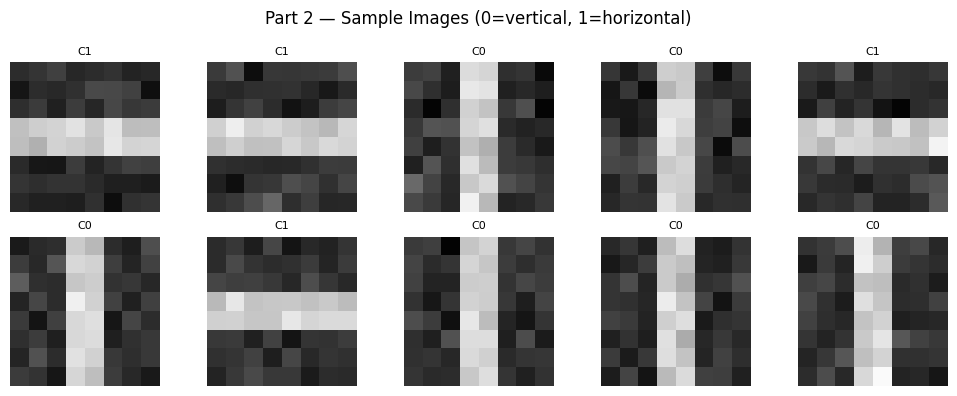

In [15]:
# ─────────────────────────────────────
# DATASET — Synthetic 8×8 Images (Option A)
# ─────────────────────────────────────
def make_image_dataset(N=3000, noise=0.1):
    imgs, labels = [], []
    for _ in range(N):
        img = np.zeros((8, 8))
        label = np.random.randint(0, 2)
        if label == 0:               # vertical center line  (col 3 or 4)
            img[:, 3] = 1.0
            img[:, 4] = 1.0
        else:                        # horizontal center line (row 3 or 4)
            img[3, :] = 1.0
            img[4, :] = 1.0
        img += np.random.randn(8, 8) * noise
        imgs.append(img)
        labels.append(label)
    return np.array(imgs), np.array(labels).reshape(-1,1).astype(float)

X_img, y_img = make_image_dataset(N=3000, noise=0.1)
print(f'Image dataset: {X_img.shape}, Labels: {y_img.shape}')

# Split
idx = np.random.permutation(3000)
te, ve = int(0.70*3000), int(0.85*3000)
Xi_tr, yi_tr = X_img[idx[:te]],   y_img[idx[:te]]
Xi_v,  yi_v  = X_img[idx[te:ve]], y_img[idx[te:ve]]
Xi_te, yi_te = X_img[idx[ve:]],   y_img[idx[ve:]]
print(f'Train: {Xi_tr.shape}  Val: {Xi_v.shape}  Test: {Xi_te.shape}')

# Visualise some samples
fig, axes = plt.subplots(2, 5, figsize=(10,4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_img[i], cmap='gray', vmin=-0.3, vmax=1.3)
    ax.set_title(f'C{int(y_img[i,0])}', fontsize=8)
    ax.axis('off')
plt.suptitle('Part 2 — Sample Images (0=vertical, 1=horizontal)')
plt.tight_layout(); plt.savefig('p2_samples.png', dpi=100); plt.show()

In [16]:
# ─────────────────────────────────────
# TASK 2A — Dense Baseline
# ─────────────────────────────────────
# Flatten 8×8 = 64 inputs
Xi_tr_flat = Xi_tr.reshape(len(Xi_tr), -1)   # (2100, 64)
Xi_v_flat  = Xi_v.reshape(len(Xi_v), -1)
Xi_te_flat = Xi_te.reshape(len(Xi_te), -1)

dense_baseline = DenseNet([64, 32, 1], activation='relu')
dense_baseline.count_params()

hist_dense = train_dense(dense_baseline, Xi_tr_flat, yi_tr,
                         Xi_v_flat, yi_v, optimizer='momentum',
                         lr=0.01, epochs=300)

y_hat_te_d = dense_baseline.forward(Xi_te_flat)
hist_dense['test_acc']  = accuracy(y_hat_te_d, yi_te)
hist_dense['test_loss'] = bce_loss(y_hat_te_d, yi_te)

print(f'Dense Baseline — Val Acc: {hist_dense["val_acc"][-1]:.4f} | Test Acc: {hist_dense["test_acc"]:.4f}')

  Total parameters: 2113
  Layer 1: W(64, 32) + b(1, 32) = 2080
  Layer 2: W(32, 1) + b(1, 1) = 33
Dense Baseline — Val Acc: 1.0000 | Test Acc: 1.0000


In [17]:
# ─────────────────────────────────────
# CNN FROM SCRATCH
# ─────────────────────────────────────

def conv2d_forward(X, K, b_conv):
    """
    X      : (N, H, W, Cin)
    K      : (F, F, Cin, Cout)
    b_conv : (Cout,)
    returns: (N, H-F+1, W-F+1, Cout)
    """
    N, H, W, Cin = X.shape
    F = K.shape[0]
    Cout = K.shape[3]
    H_out = H - F + 1
    W_out = W - F + 1
    out = np.zeros((N, H_out, W_out, Cout))
    for i in range(H_out):
        for j in range(W_out):
            patch = X[:, i:i+F, j:j+F, :]   # (N, F, F, Cin)
            # einsum: sum over F,F,Cin → Cout
            out[:, i, j, :] = np.tensordot(patch, K, axes=([1,2,3],[0,1,2])) + b_conv
    return out

def conv2d_backward(X, K, dout):
    """
    Returns dX, dK, db_conv
    """
    N, H, W, Cin = X.shape
    F = K.shape[0]
    Cout = K.shape[3]
    H_out, W_out = dout.shape[1], dout.shape[2]
    dX = np.zeros_like(X)
    dK = np.zeros_like(K)
    db = np.sum(dout, axis=(0,1,2))
    for i in range(H_out):
        for j in range(W_out):
            patch = X[:, i:i+F, j:j+F, :]           # (N,F,F,Cin)
            d     = dout[:, i, j, :]                 # (N, Cout)
            dK   += np.tensordot(patch, d, axes=([0],[0]))   # (F,F,Cin,Cout)
            dX[:, i:i+F, j:j+F, :] += np.tensordot(d, K, axes=([1],[3]))  # (N,F,F,Cin)
    return dX, dK, db

def maxpool2d_forward(X, pool_size=2):
    """X: (N,H,W,C)  → (N, H//p, W//p, C)"""
    N, H, W, C = X.shape
    p = pool_size
    H2, W2 = H // p, W // p
    out  = np.zeros((N, H2, W2, C))
    mask = np.zeros_like(X)
    for i in range(H2):
        for j in range(W2):
            patch = X[:, i*p:(i+1)*p, j*p:(j+1)*p, :]
            val   = np.max(patch, axis=(1,2), keepdims=True)  # (N,1,1,C)
            out[:, i, j, :] = val[:, 0, 0, :]
            mask[:, i*p:(i+1)*p, j*p:(j+1)*p, :] = (patch == val)
    return out, mask

def maxpool2d_backward(dout, mask, pool_size=2):
    N, H2, W2, C = dout.shape
    p = pool_size
    dX = np.zeros((N, H2*p, W2*p, C))
    for i in range(H2):
        for j in range(W2):
            d = dout[:, i, j, :][:, None, None, :]   # (N,1,1,C)
            dX[:, i*p:(i+1)*p, j*p:(j+1)*p, :] += d * mask[:, i*p:(i+1)*p, j*p:(j+1)*p, :]
    return dX

print('Conv & Pool ops defined ✓')

Conv & Pool ops defined ✓


In [18]:
# ─────────────────────────────────────
# CNN CLASS
# ─────────────────────────────────────
class SimpleCNN:
    """
    Architecture:
      Conv(F×F, Cin=1, Cout) → ReLU → MaxPool(2) → Flatten → Dense → Sigmoid
    Optional: dropout on dense layer
    Optional: skip pooling
    """
    def __init__(self, img_size=8, F=3, Cout=4, use_pool=True, dropout_rate=0.0):
        self.F = F
        self.Cout = Cout
        self.use_pool = use_pool
        self.dropout_rate = dropout_rate
        self.pool_size = 2

        # Conv kernel: (F, F, 1, Cout)
        self.K  = np.random.randn(F, F, 1, Cout) * np.sqrt(2.0 / (F*F))
        self.bK = np.zeros(Cout)

        # compute flatten size
        H_conv = img_size - F + 1
        if use_pool:
            H_flat = (H_conv // self.pool_size) ** 2 * Cout
        else:
            H_flat = H_conv ** 2 * Cout
        self.H_flat = H_flat

        # Dense: H_flat → 1
        self.W2 = np.random.randn(H_flat, 1) * np.sqrt(2.0 / H_flat)
        self.b2 = np.zeros((1, 1))

        conv_params = F*F*1*Cout + Cout
        dense_params = H_flat + 1
        self.n_params = conv_params + dense_params
        print(f'CNN params — Conv: {conv_params}, Dense: {dense_params}, Total: {self.n_params}')

    def forward(self, X, training=False):
        """
        X: (N, 8, 8) → expand to (N, 8, 8, 1)
        """
        self.X_in = X[:, :, :, np.newaxis]    # (N,8,8,1)
        # Conv
        self.conv_out = conv2d_forward(self.X_in, self.K, self.bK)
        self.relu_out = relu(self.conv_out)
        # Pool
        if self.use_pool:
            self.pool_out, self.pool_mask = maxpool2d_forward(self.relu_out, self.pool_size)
            flat = self.pool_out.reshape(X.shape[0], -1)
        else:
            self.pool_out = self.relu_out
            self.pool_mask = None
            flat = self.relu_out.reshape(X.shape[0], -1)
        self.flat = flat
        # Dropout
        if training and self.dropout_rate > 0:
            self.drop_mask = (np.random.rand(*flat.shape) > self.dropout_rate).astype(float)
            flat = flat * self.drop_mask / (1 - self.dropout_rate)
        else:
            self.drop_mask = np.ones_like(flat)
        self.flat_dropped = flat
        # Dense
        self.z2   = flat @ self.W2 + self.b2
        self.out  = sigmoid(self.z2)
        return self.out

    def backward(self, y):
        N = y.shape[0]
        # Output gradient
        dz2 = bce_grad(self.out, y) * sigmoid_d(self.z2)
        dW2 = self.flat_dropped.T @ dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)
        d_flat = dz2 @ self.W2.T

        # Dropout backward
        d_flat = d_flat * self.drop_mask / max(1 - self.dropout_rate, 1e-8)

        # Unflatten
        d_pool = d_flat.reshape(self.pool_out.shape)

        # Pool backward
        if self.use_pool:
            d_relu = maxpool2d_backward(d_pool, self.pool_mask, self.pool_size)
        else:
            d_relu = d_pool

        # ReLU backward
        d_conv = d_relu * relu_d(self.conv_out)

        # Conv backward
        dX_in, dK, dbK = conv2d_backward(self.X_in, self.K, d_conv)

        grad_norm_conv  = np.sqrt(np.sum(dK**2))
        grad_norm_dense = np.sqrt(np.sum(dW2**2))
        return {'dK': dK, 'dbK': dbK, 'dW2': dW2, 'db2': db2,
                'gnorms': [grad_norm_conv, grad_norm_dense]}

    def apply_gradients(self, grads, lr=0.01):
        self.K  -= lr * grads['dK']
        self.bK -= lr * grads['dbK']
        self.W2 -= lr * grads['dW2']
        self.b2 -= lr * grads['db2']

print('SimpleCNN class defined ✓')

SimpleCNN class defined ✓


In [21]:
# ─────────────────────────────────────
# CNN TRAINING LOOP
# ─────────────────────────────────────
def train_cnn(cnn, X_tr, y_tr, X_v, y_v, optimizer='sgd',
              lr=0.01, epochs=300, batch_size=64, verbose=False):
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[], 'grad_norms':[]}
    N = X_tr.shape[0]
    # momentum / adam state
    v_state  = {k: np.zeros_like(v) for k, v in {'K': cnn.K, 'bK': cnn.bK, 'W2': cnn.W2, 'b2': cnn.b2}.items()}
    m_state  = deepcopy(v_state)
    t = 0

    for epoch in range(1, epochs+1):
        idx = np.random.permutation(N)
        for start in range(0, N, batch_size):
            batch = idx[start:start+batch_size]
            Xb, yb = X_tr[batch], y_tr[batch]
            cnn.forward(Xb, training=True)
            grads = cnn.backward(yb)

            # param update per optimizer
            for p_name, dp_name in [('K','dK'),('bK','dbK'),('W2','dW2'),('b2','db2')]:
                g = grads[dp_name]
                p = getattr(cnn, p_name)
                if optimizer == 'sgd':
                    p -= lr * g
                elif optimizer == 'momentum':
                    v_state[p_name] = 0.9 * v_state[p_name] + lr * g
                    p -= v_state[p_name]
                elif optimizer == 'adam':
                    t_local = epoch  # approximate
                    m_state[p_name] = 0.9 * m_state[p_name] + 0.1 * g
                    v_state[p_name] = 0.999 * v_state[p_name] + 0.001 * g**2
                    mh = m_state[p_name] / (1 - 0.9**max(t_local,1))
                    vh = v_state[p_name] / (1 - 0.999**max(t_local,1))
                    p -= lr * mh / (np.sqrt(vh) + 1e-8)
                setattr(cnn, p_name, p)

        # metrics
        # Calculate validation metrics first to avoid overwriting cnn.out before train metrics
        y_v_hat  = cnn.forward(X_v)
        history['val_loss'].append(bce_loss(y_v_hat, y_v))
        history['val_acc'].append(accuracy(y_v_hat, y_v))

        # Calculate train metrics and gradient norms
        y_tr_hat = cnn.forward(X_tr) # Ensure cnn.out is based on X_tr for backward pass
        g        = cnn.backward(y_tr)['gnorms'] # now cnn.out and y_tr match in size
        history['train_loss'].append(bce_loss(y_tr_hat, y_tr))
        history['train_acc'].append(accuracy(y_tr_hat, y_tr))
        history['grad_norms'].append(g)

        if verbose and epoch % 50 == 0:
            print(f'Epoch {epoch:3d} | Loss {history["train_loss"][-1]:.4f} | Val Acc {history["val_acc"][-1]:.4f}')
    return history

print('CNN training loop defined ✓')

CNN training loop defined ✓


In [22]:
# ─────────────────────────────────────
# TASK 2D — Structural Experiments
# ─────────────────────────────────────
CNN_CONFIGS = {
    'CNN_pool':           dict(use_pool=True,  dropout_rate=0.0),
    'CNN_no_pool':        dict(use_pool=False, dropout_rate=0.0),
    'CNN_dropout':        dict(use_pool=True,  dropout_rate=0.3),
    'CNN_no_dropout':     dict(use_pool=True,  dropout_rate=0.0),  # same as pool
}

CNN_LR = 0.005
CNN_EPOCHS = 300

results_p2 = {}
for name, cfg in CNN_CONFIGS.items():
    print(f'Training {name} ...', end=' ')
    cnn = SimpleCNN(img_size=8, F=3, Cout=4, **cfg)
    hist = train_cnn(cnn, Xi_tr, yi_tr, Xi_v, yi_v,
                     optimizer='momentum', lr=CNN_LR, epochs=CNN_EPOCHS)
    y_hat = cnn.forward(Xi_te)
    hist['test_acc']  = accuracy(y_hat, yi_te)
    hist['test_loss'] = bce_loss(y_hat, yi_te)
    hist['cnn']       = cnn
    results_p2[name]  = hist
    print(f'Val Acc: {hist["val_acc"][-1]:.4f} | Test Acc: {hist["test_acc"]:.4f}')

# Also record dense baseline
results_p2['Dense_baseline'] = hist_dense
results_p2['Dense_baseline']['test_acc'] = hist_dense['test_acc']

Training CNN_pool ... CNN params — Conv: 40, Dense: 37, Total: 77
Val Acc: 1.0000 | Test Acc: 1.0000
Training CNN_no_pool ... CNN params — Conv: 40, Dense: 145, Total: 185
Val Acc: 1.0000 | Test Acc: 1.0000
Training CNN_dropout ... CNN params — Conv: 40, Dense: 37, Total: 77
Val Acc: 1.0000 | Test Acc: 1.0000
Training CNN_no_dropout ... CNN params — Conv: 40, Dense: 37, Total: 77
Val Acc: 1.0000 | Test Acc: 1.0000


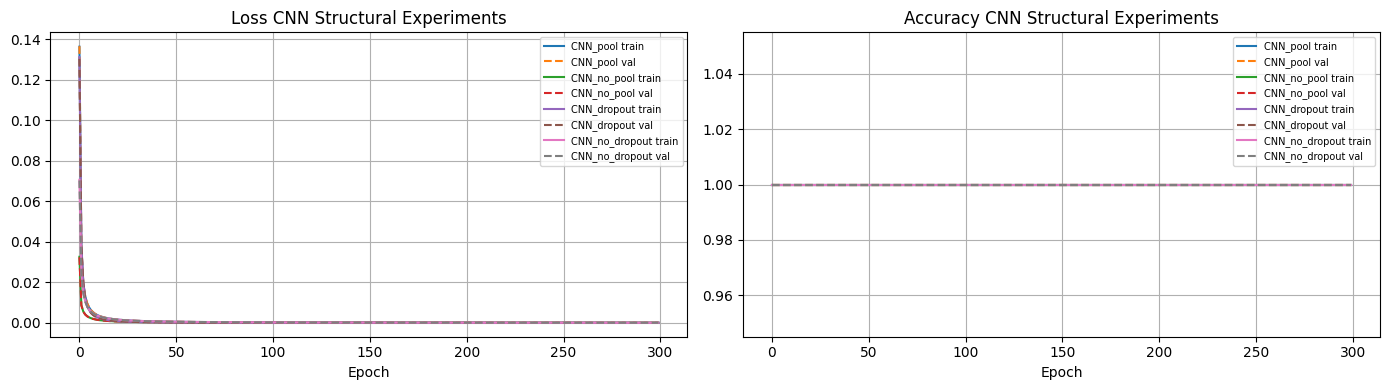

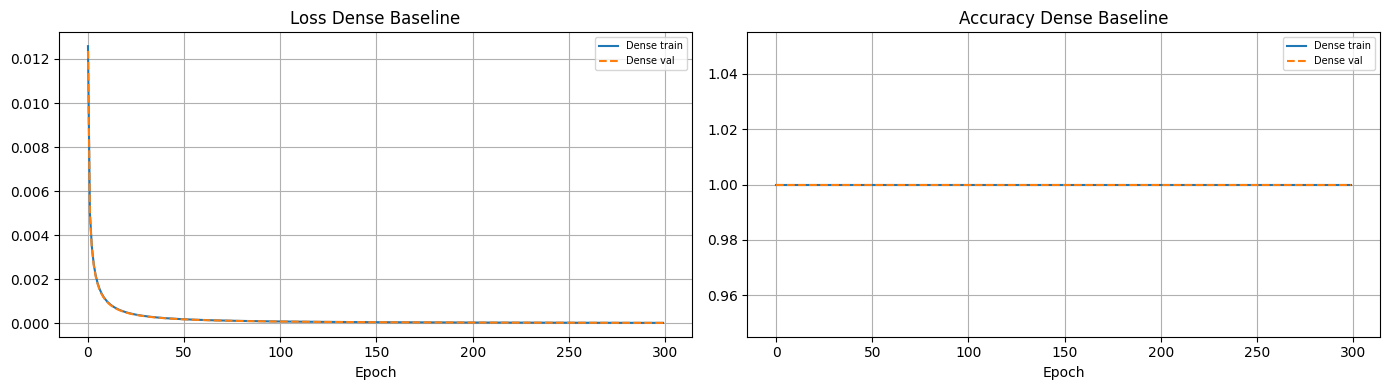


── Part 2 Results ──
Model                Params   TrainAcc   ValAcc     TestAcc
------------------------------------------------------------
Dense_baseline       2113     1.0000     1.0000     1.0000
CNN_pool             77       1.0000     1.0000     1.0000
CNN_no_pool          185      1.0000     1.0000     1.0000
CNN_dropout          77       1.0000     1.0000     1.0000
CNN_no_dropout       77       1.0000     1.0000     1.0000


In [23]:
# Plot Part 2
plot_history({k: v for k, v in results_p2.items() if k != 'Dense_baseline'},
             title_suffix='CNN Structural Experiments', save_prefix='p2')
plot_history({'Dense': hist_dense}, title_suffix='Dense Baseline', save_prefix='p2')

print('\n── Part 2 Results ──')
print(f'{"Model":<20} {"Params":<8} {"TrainAcc":<10} {"ValAcc":<10} {"TestAcc"}')
print('-'*60)
print(f'{"Dense_baseline":<20} {dense_baseline.n_params:<8} '
      f'{hist_dense["train_acc"][-1]:.4f}     '
      f'{hist_dense["val_acc"][-1]:.4f}     '
      f'{hist_dense["test_acc"]:.4f}')
for name, hist in results_p2.items():
    if name == 'Dense_baseline': continue
    n_p = hist['cnn'].n_params
    print(f'{name:<20} {n_p:<8} {hist["train_acc"][-1]:.4f}     '
          f'{hist["val_acc"][-1]:.4f}     {hist["test_acc"]:.4f}')

Part 3 — CNN with sgd (lr=0.01) ... CNN params — Conv: 40, Dense: 37, Total: 77
Val: 1.0000 | Test: 1.0000
Part 3 — CNN with momentum (lr=0.005) ... CNN params — Conv: 40, Dense: 37, Total: 77
Val: 1.0000 | Test: 1.0000
Part 3 — CNN with adam (lr=0.001) ... CNN params — Conv: 40, Dense: 37, Total: 77
Val: 1.0000 | Test: 1.0000


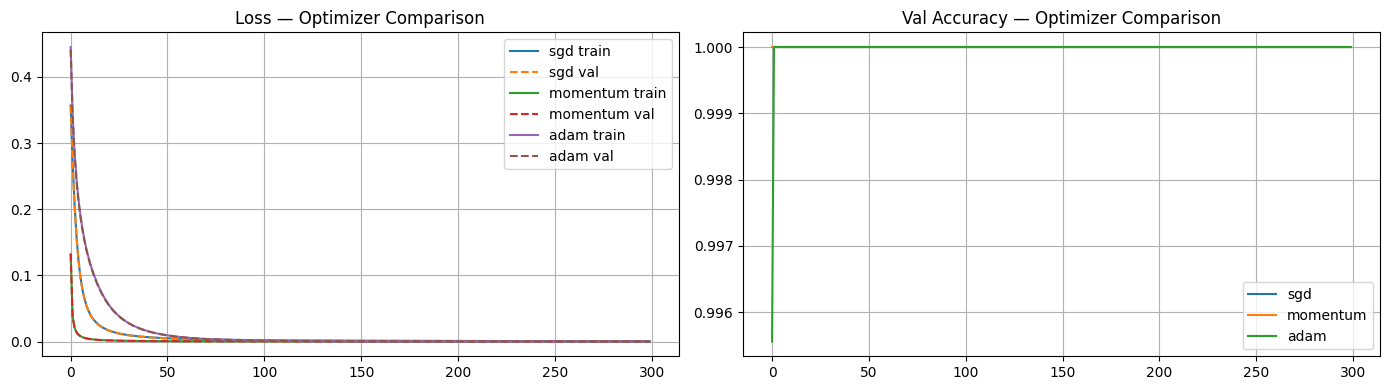


── Part 3 Results ──
Optimizer    TrainAcc   ValAcc     TestAcc    Convergence (epoch@0.9acc)
-----------------------------------------------------------------
sgd          1.0000     1.0000     1.0000     epoch 0
momentum     1.0000     1.0000     1.0000     epoch 0
adam         1.0000     1.0000     1.0000     epoch 0


In [24]:
# Best CNN from Part 2 → train with SGD, Momentum, Adam
P3_EPOCHS = 300
results_p3 = {}

OPT_LRS = {'sgd': 0.01, 'momentum': 0.005, 'adam': 0.001}

for opt_name, lr in OPT_LRS.items():
    print(f'Part 3 — CNN with {opt_name} (lr={lr}) ...', end=' ')
    cnn = SimpleCNN(img_size=8, F=3, Cout=4, use_pool=True, dropout_rate=0.0)
    hist = train_cnn(cnn, Xi_tr, yi_tr, Xi_v, yi_v,
                     optimizer=opt_name, lr=lr, epochs=P3_EPOCHS)
    y_hat = cnn.forward(Xi_te)
    hist['test_acc']  = accuracy(y_hat, yi_te)
    hist['test_loss'] = bce_loss(y_hat, yi_te)
    results_p3[opt_name] = hist
    print(f'Val: {hist["val_acc"][-1]:.4f} | Test: {hist["test_acc"]:.4f}')

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
for opt_name, hist in results_p3.items():
    axes[0].plot(hist['train_loss'], label=f'{opt_name} train')
    axes[0].plot(hist['val_loss'], linestyle='--', label=f'{opt_name} val')
    axes[1].plot(hist['val_acc'],  label=opt_name)
axes[0].set_title('Loss — Optimizer Comparison'); axes[0].legend()
axes[1].set_title('Val Accuracy — Optimizer Comparison'); axes[1].legend()
plt.tight_layout(); plt.savefig('p3_optimizer_comparison.png', dpi=100); plt.show()

print('\n── Part 3 Results ──')
print(f'{"Optimizer":<12} {"TrainAcc":<10} {"ValAcc":<10} {"TestAcc":<10} {"Convergence (epoch@0.9acc)"}')
print('-'*65)
for opt_name, hist in results_p3.items():
    va = np.array(hist['val_acc'])
    conv_ep = next((i for i,v in enumerate(va) if v >= 0.90), -1)
    print(f'{opt_name:<12} {hist["train_acc"][-1]:.4f}     '
          f'{hist["val_acc"][-1]:.4f}     '
          f'{hist["test_acc"]:.4f}     '
          f'epoch {conv_ep if conv_ep != -1 else "N/A"}')

In [25]:
# ─────────────────────────────────────
# MASTER RESULT TABLE — All Experiments
# ─────────────────────────────────────
print('=' * 95)
print(f'{"Model":<18} {"Act":<8} {"Opt":<10} {"Params":<8} {"TrainAcc":<10} {"ValAcc":<10} {"TestAcc":<10} Notes')
print('=' * 95)

# Part 1
for arch_name, dims in ARCHITECTURES.items():
    for act in ACTIVATIONS:
        for opt in OPTIMIZERS:
            h = results_p1[(arch_name, act, opt)]
            note = ''
            if arch_name == '10-layer' and act == 'sigmoid': note = '← Vanishing grad'
            if arch_name == '10-layer' and act == 'relu': note = '← Better depth'
            print(f'{arch_name:<18} {act:<8} {opt:<10} {h["net"].n_params:<8} '
                  f'{h["train_acc"][-1]:.4f}     '
                  f'{h["val_acc"][-1]:.4f}     '
                  f'{h["test_acc"]:.4f}     {note}')

print('-'*95)
# Part 2
print(f'{"Dense_baseline":<18} {"relu":<8} {"momentum":<10} {dense_baseline.n_params:<8} '
      f'{hist_dense["train_acc"][-1]:.4f}     '
      f'{hist_dense["val_acc"][-1]:.4f}     '
      f'{hist_dense["test_acc"]:.4f}     ← Flat input, no spatial')
for name, hist in results_p2.items():
    if name == 'Dense_baseline': continue
    n_p = hist['cnn'].n_params
    print(f'{name:<18} {"relu":<8} {"momentum":<10} {n_p:<8} '
          f'{hist["train_acc"][-1]:.4f}     '
          f'{hist["val_acc"][-1]:.4f}     '
          f'{hist["test_acc"]:.4f}')

print('-'*95)
# Part 3
for opt_name, hist in results_p3.items():
    print(f'{"CNN_best":<18} {"relu":<8} {opt_name:<10} {77:<8} '
          f'{hist["train_acc"][-1]:.4f}     '
          f'{hist["val_acc"][-1]:.4f}     '
          f'{hist["test_acc"]:.4f}')
print('=' * 95)

Model              Act      Opt        Params   TrainAcc   ValAcc     TestAcc    Notes
2-layer            sigmoid  sgd        65       0.9710     0.9800     0.9733     
2-layer            sigmoid  momentum   65       0.9957     0.9956     0.9889     
2-layer            relu     sgd        65       0.9933     0.9889     0.9889     
2-layer            relu     momentum   65       0.9967     0.9978     0.9867     
5-layer            sigmoid  sgd        881      0.9733     0.9778     0.9689     
5-layer            sigmoid  momentum   881      0.9881     0.9889     0.9711     
5-layer            relu     sgd        881      0.9981     0.9933     0.9889     
5-layer            relu     momentum   881      0.9871     0.9800     0.9778     
10-layer           sigmoid  sgd        2241     0.5414     0.5200     0.5356     ← Vanishing grad
10-layer           sigmoid  momentum   2241     0.5414     0.5200     0.5356     ← Vanishing grad
10-layer           relu     sgd        2241     0.9910     0.